## Import Dependencies

In [57]:
import pandas as pd
import numpy as np
import transformers
import torch
import shap
import scipy as sp
from tqdm.notebook import tqdm
import scipy
import matplotlib.pyplot as plt

## Load Dataset

Movie Review

In [3]:
import os
import sys
sys.path.append('../')
from eraserbenchmark.rationale_benchmark.utils import load_documents, load_datasets, annotations_from_jsonl, Annotation

data_root = os.path.join('../eraserbenchmark/data', 'movies')
documents = load_documents(data_root)
train, val, test = load_datasets(data_root)

In [31]:
data_raw = train[5]
data_raw.__dict__

{'annotation_id': 'negR_005.txt',
 'query': 'What is the sentiment of this review?',
 'evidences': frozenset({(Evidence(text='also unimpressive', docid='negR_005.txt', start_token=631, end_token=633, start_sentence=30, end_sentence=31),),
            (Evidence(text='it is a very bad mistake to make', docid='negR_005.txt', start_token=107, end_token=115, start_sentence=6, end_sentence=7),),
            (Evidence(text='sadly what follows is not really up to the buildup', docid='negR_005.txt', start_token=549, end_token=559, start_sentence=26, end_sentence=27),),
            (Evidence(text='tacky looking rundown martian mining colony', docid='negR_005.txt', start_token=405, end_token=411, start_sentence=19, end_sentence=20),),
            (Evidence(text='that still does not make for a really good science fiction experience', docid='negR_005.txt', start_token=218, end_token=230, start_sentence=11, end_sentence=12),),
            (Evidence(text='these are standard haunted house film shock e

In [4]:
import string
def obtain_text_review(data_raw, documents, token_length=256):
    word_list = [word for sent in documents[data_raw.annotation_id][:token_length] for word in sent+["\n"]][:token_length]
    word_list_refined = [" "+word if word not in string.punctuation else word for word in word_list ]
    paragraph = "".join(word_list_refined)[1:]
    return paragraph

from collections import Counter
data_split = train
token_length = 400
label_types = {'POS':'positive', 'NEG':'negative'}

df = pd.DataFrame(columns=['review', 'label'])
for data_raw in data_split:
    review = obtain_text_review(data_raw, documents, token_length)
    label = data_raw.classification
    df.loc[len(df)] = [review, label_types[label]]

counts = df['label'].value_counts()
counts

negative    800
positive    800
Name: label, dtype: int64

## Get Explanations and SHAP score

### GPT explanation

In [5]:
# imports
import os
import ast  # for converting embeddings saved as strings back to arrays
import openai  
import pandas as pd
import tiktoken  # for counting tokens
from tqdm.auto import tqdm
from scipy import spatial  # for calculating vector similarities for search
openai.api_key = os.environ["OPENAI_API_KEY"]

# models
EMBEDDING_MODEL = "text-embedding-ada-002"
# GPT_MODEL = "gpt-3.5-turbo-16k-0613"
GPT_MODEL = "gpt-4-0613" # According to OpenAI, GPT-4 is more responsive to system messages, whereas 3.5 would rely on more of the user input.


### Get summary

In [ ]:
def summarize(input_premise, is_query=False, n_reviews=None):
    if is_query:
        query = input_premise
        n_reviews = n_reviews
    else:
        query = []
        for x in input_premise:
            query.append(f">>>Review starts\n{x}\n>>>Review ends\n")
        query = "\n".join(query)
        n_reviews = len(input_premise)
    # Please shorten each of the following movie reivews in between 48-96 words in the tone of the reviewer while trying to preserve its meanings.

    sys_msg = f"""
    Please extract the opinions and rewrite the following movie reviews pretending you are the original reviewer, each in about 32 words. 
    Note: Treat each review independently. The start and end of an review is marked by ">>>Review starts" and ">>>Review ends".

    Reply in the following format: 
    The response to each review contains 1 line, which is the shortened version of the review.
    If there are more than 2 reviews, the replies should be are serparated by a new line of "---".
    
    If you feel impossible to summary, please put "I can't summary this review" at the corresponding line.
    The followings are examples of valid replies:
    
    your summary 1
    ---
    I can't summary this review
    ---
    your summary 3
    """

    response = openai.ChatCompletion.create(
            messages=[
                {'role': 'system', 'content': sys_msg},
                {'role': 'user', 'content': query},
            ],
            model=GPT_MODEL,
            temperature=0,
        )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts+1 == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts+1} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError
    summarized_reviews = model_response.split("\n---\n")
    return summarized_reviews

summaries_list = []
batch_size = 5
sample_size = 120



new_df = df.sample(120).copy().reset_index(drop=True)
for i in tqdm(range(0, sample_size, batch_size)):
    summaries_list.extend(summarize(df.review[i:i+batch_size]))
new_df['review'] = summaries_list
new_df.to_csv(f'movies_{sample_size}.csv', index=False)

In [ ]:
np.random.choice(summaries_list, 10)

array(['"Love to Kill" is a crime film that attempts to blend humor and levity into the genre but ends up being a convoluted mess. The only redeeming aspect is the relationship between Tony Danza\'s character and the sister of a deceased woman. Danza\'s performance is impressive, but the film overall fails to deliver.',
       '"Species II" is a sequel that fails to improve upon its predecessor. Despite its potentially intriguing premise, the film is riddled with plot holes, ridiculous dialogue, and unconvincing special effects. The performances are lackluster, and the plot is often nonsensical.',
       '"Get Carter" is a disappointing action film, with Sylvester Stallone failing to recapture his 80\'s action hero glory. Despite strong performances from Mickey Rourke and Michael Caine, the film is let down by a weak script and poor casting.',
       '"Hard to Die" is a predictable, low-budget horror flick with a ridiculous storyline and poor acting. The special effects are unrealistic

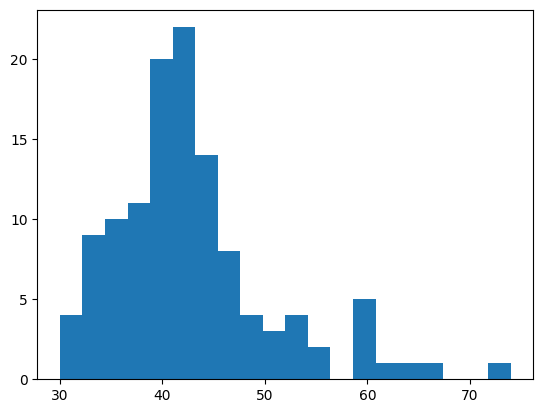

In [ ]:
wc = [len(x.split(' ')) for x in summaries_list]
import matplotlib.pyplot as plt
plt.hist(wc, bins=20)
plt.show()

### Get NLE

In [7]:
# an example nle question

def prediction_function(input_premise, input_label, is_query=False, n_reviews=None):
    if is_query:
        query = input_premise
        n_reviews = n_reviews
    else:
        query = []
        for i, (x, y) in enumerate(zip(input_premise, input_label)):
            query.append(f">>>Review {i} starts\n{x}\n>>>Review {i} ends\n>>>The sentiment is {y}\n")
        query = "".join(query)
        n_reviews = len(input_premise)
    sys_msg = f"""
    Given the following movie reviews and their sentiment judgement, please explain the reason for each judgement/
    Note: Treat each review independently. The start and end of an review is marked by ">>>Review i starts" and ">>>Review i ends" where i is the number. The sentiment is marked by ">>>The sentiment is positive/negetive". When reply, please do not include the review number.

    Reply in the following format: 
    The reply to each review contains 2 lines.
    The first line is your explanation. (Please do not use any special character)
    The second line is a seperator "---" marking the end of the reply.
    There should be no new line between consecutive replies.
    
    The followings are examples of a valid response that contains 4 replies, followed by 4 lines of "---":
    your explanation
    ---
    your explanation
    ---
    your explanation
    ---
    your explanation
    ---
    """

    response = openai.ChatCompletion.create(
        messages=[
            {'role': 'system', 'content': sys_msg},
            {'role': 'user', 'content': query},
        ],
        model=GPT_MODEL,
        temperature=0,
    )

    model_response = response['choices'][0]['message']['content']
    reply_counts = model_response.count("\n---")
    try:
        assert reply_counts == n_reviews
    except AssertionError:
        print(">>>>>>>>>>>>AssertionError:")
        print(f"number of replies {reply_counts} does not match number of reviews {n_reviews}")
        print(query)
        print(model_response)
        raise AssertionError

    model_nle_list = []
    model_response += '\n'
    for line in model_response.split("\n---\n")[:-1]:
        try:
            model_nle = line.split('\n')
            model_nle_list.append(model_nle)
        except:
            print(">>>>>>>>>>>>Exception: model reply in wrong format for one reply")
            print(query)
            print(model_response)
            raise AssertionError
    return model_nle_list



In [8]:
# sample_df = pd.read_csv('../movies_120.csv')
import time
sample_size = 320
sample_df = df.sample(sample_size).copy().reset_index(drop=True)
batch_size = 8
sample_df['nle'] = None
for i in tqdm(range(0, len(sample_df), batch_size)):
    # time.sleep(10)
    # if i % batch_size*10 == 0: time.sleep(30)
    list_nle = prediction_function(sample_df.review[i:i+batch_size].tolist(), sample_df.label[i:i+batch_size].tolist())
    sample_df.loc[i:i+batch_size-1, 'nle'] = list_nle
sample_df.to_csv(f'../movies_400_{sample_size}_nle.csv', index=False)

  0%|          | 0/40 [00:00<?, ?it/s]

## BERT pretrained on Sentiment analysis

In [222]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("wesleyacheng/movie-review-sentiment-classifier-with-bert")
model = AutoModelForSequenceClassification.from_pretrained("wesleyacheng/movie-review-sentiment-classifier-with-bert").to('cuda')
inputs = tokenizer("I love AutoTrain", return_tensors="pt").to('cuda')
outputs = model(**inputs).detach().cpu().numpy()

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[[{'label': 'NEGATIVE', 'score': 0.00040165119571611285},
  {'label': 'POSITIVE', 'score': 0.9995983242988586}]]

In [88]:
import torch
label_map = ['negative', 'positive']
prob = torch.nn.functional.softmax(outputs.logits.detach().cpu(), dim=-1)
label_map[torch.argmax(prob).item()]

'positive'

In [65]:
outs = model(**tokenizer(sample_df.review[:3].tolist(), return_tensors="pt", padding=True))
outs = outs[0].detach().cpu().numpy()
outs

array([[ 1.9883655, -2.4256253],
       [ 2.2382267, -2.6536348],
       [ 2.439368 , -2.8668327]], dtype=float32)

In [66]:
import scipy as sp
scores = (np.exp(outs).T / np.exp(outs).sum(-1)).T
val = sp.special.logit(scores)
val

array([[ 4.4139915, -4.413991 ],
       [ 4.891864 , -4.8918614],
       [ 5.3061953, -5.3062005]], dtype=float32)

In [138]:
import shap
from functools import partial
from tqdm.auto import tqdm
import scipy as sp
    
def f(x, batch_size=8, device='cuda'):
    outputs = []
    for i in range(0, len(x), batch_size):
        _x = x[i:i+batch_size].copy()
        model_input = tokenizer(list(_x), return_tensors="pt", padding=True).to(device)
        logits = model(**model_input).logits.detach().cpu().numpy()
        outputs.append(logits)
    outputs = np.vstack(outputs)
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores)
    return val

sample_df = pd.read_csv('../movies_120_nle.csv')
sample_df['shap_values'] = None
sample_df['shap_base_values'] =  None
sample_df['shap_data'] =  None
sample_df['y_prob'] = None
sample_df['model_nle'] = None

explainer = shap.Explainer(partial(f, batch_size=8), masker=tokenizer, output_names=label_map)
shap_values = explainer(sample_df.review.tolist())

Partition explainer: 121it [00:47,  2.03it/s]                         


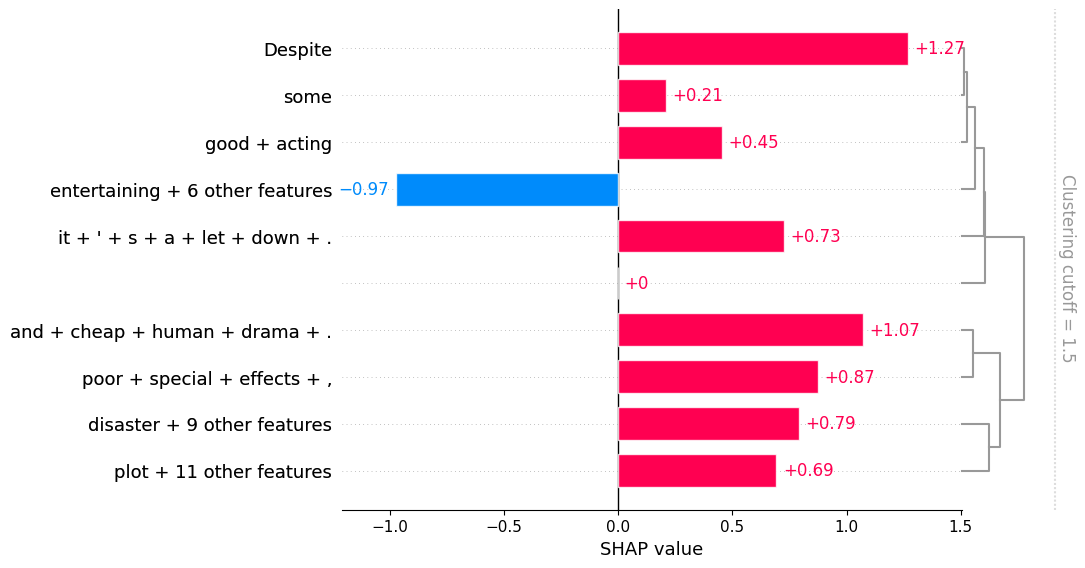

In [198]:
instance = shap_values[100,:,'negative']
# instance[np.argmax(np.abs(instance))[:3]]
# np.argsort(np.abs(instance))
# np.abs(instance)
instance.clustering
# len(instance.values)
# sp.cluster.hierarchy.dendrogram(instance.clustering)
shap.plots.bar(instance, clustering_cutoff=1.5)

In [219]:
# instance.data[[10,11, 12,13]]
instance.data

array(['', '"', 'Deep ', 'Impact', '" ', 'is ', 'a ', 'disaster ',
       'film ', 'that ', 'di', 'sa', 'pp', 'oint', 's ', 'with ', 'its ',
       'imp', 'laus', 'ible ', 'plot', ', ', 'poor ', 'special ',
       'effects', ', ', 'and ', 'cheap ', 'human ', 'drama', '. ',
       'Despite ', 'some ', 'good ', 'acting ', 'and ', 'an ',
       'entertaining ', 'final ', '15 ', 'minutes', ', ', 'it', "'", 's ',
       'a ', 'let', 'down', '.', ''], dtype='<U13')

In [ ]:
instance.clustering[:,:2]

## BERT pretrained on Sentiment analysis 2

### Generate SHAP values 

In [9]:
model = transformers.pipeline('sentiment-analysis', top_k=None, device=torch.device('cuda:0'))
tokenizer = model.tokenizer

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [10]:
sample_df = pd.read_csv('../movies_400_320_nle.csv')

explainer = shap.Explainer(model)
shap_values = explainer(sample_df.review.tolist())

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Partition explainer: 321it [10:59,  2.08s/it]                         


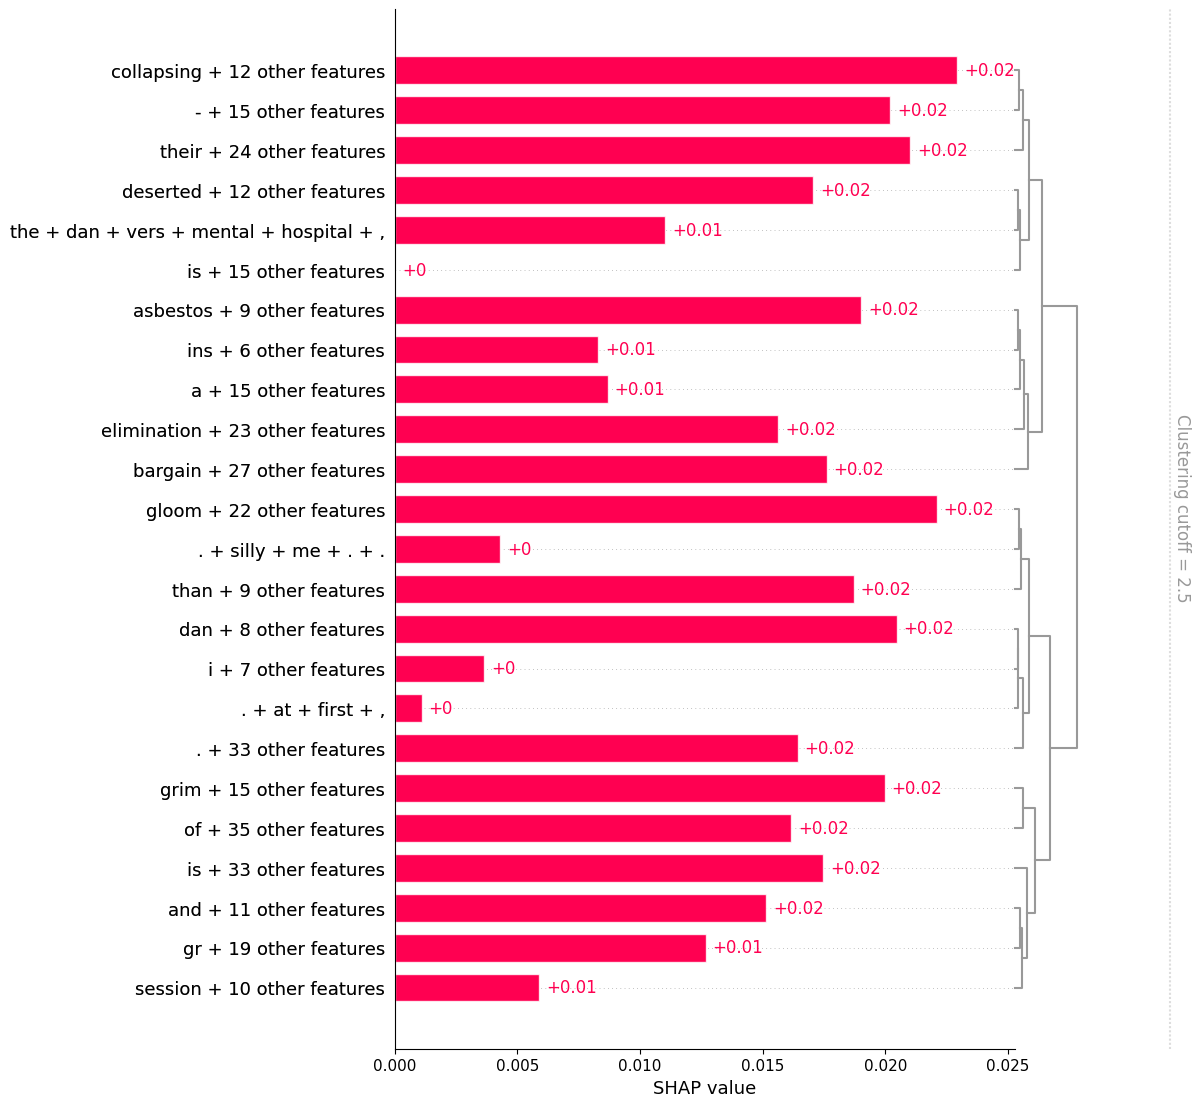

In [40]:
instance = shap_values[9,:,'NEGATIVE']
# shap.plots.bar(instance, clustering_cutoff=1)
shap.plots.bar(instance, max_display=24, clustering_cutoff=2.5)

In [41]:
sample_df.review[9]

'susan granger \'s review of" session 9"( usa films) sometimes you just get more than your bargained for... \n like when boston- based hazmat elimination, run by scottish actor peter mullan and his trusty assistant, david caruso, assures a town engineer( paul guilifoyle) that they can remove insidious asbestos fibers from a victorian hospital facility in a week. \n erected in 1871, deserted and decomposing since 1985, the danvers mental hospital, is one of the most malevolent" locations" ever chosen for a film. \n the structure is so massive- with its labyrinth of rubble- strewn corridors, collapsing floors, stagnant pools of water, isolation cells, and ominous surgical chambers where experimental pre- frontal lobotomies were performed- that their task seems impossible within that time frame. \n and each member of their inexperienced crew( stephan gevedon, brandon sexton iii, and josh lucas) is coping with his own personal demons as, one by one, their minds seem to be affected by the g

In [42]:
sample_df.nle[9]

'The review is negative because the reviewer criticizes the movie for its lack of structure and not being scary. The reviewer also mentions that the conclusion is ludicrous and the movie overall is dark and gloomy.'

In [33]:
sample_df.label[9]

'negative'

In [36]:
sample_df = pd.read_csv('../movies_400_320_nle.csv')
n = 10
sample_df[f'max_shap_value'] = None
for i in tqdm(range(len(shap_values))):
    # instance = shap_values[i,:,'POSITIVE']
    instance = shap_values[i,:,sample_df.label[i].upper()]
    pos_vals = instance.values[instance.values>0]
    max_n = np.argsort(pos_vals)[-n:]
    max_sum = pos_vals[max_n].sum()
    sample_df.loc[i, f'max_shap_value'] = max_sum

sample_df.to_csv('../movies_400_320_nle_shap.csv', index=False)

  0%|          | 0/320 [00:00<?, ?it/s]

### Explore Hierarchy

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [30.0, 30.0, 45.0, 45.0],
  [10.0, 10.0, 37.5, 37.5],
  [55.0, 55.0, 65.0, 65.0],
  [75.0, 75.0, 85.0, 85.0],
  [80.0, 80.0, 95.0, 95.0],
  [60.0, 60.0, 87.5, 87.5],
  [23.75, 23.75, 73.75, 73.75],
  [105.0, 105.0, 115.0, 115.0],
  [110.0, 110.0, 125.0, 125.0],
  [135.0, 135.0, 145.0, 145.0],
  [165.0, 165.0, 175.0, 175.0],
  [155.0, 155.0, 170.0, 170.0],
  [140.0, 140.0, 162.5, 162.5],
  [117.5, 117.5, 151.25, 151.25],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [192.5, 192.5, 222.5, 222.5],
  [134.375, 134.375, 207.5, 207.5],
  [48.75, 48.75, 170.9375, 170.9375]],
 'dcoord': [[0.0, 0.0707070707070707, 0.0707070707070707, 0.0],
  [0.0, 0.06060606060606061, 0.06060606060606061, 0.0],
  [0.06060606060606061, 0.14393939393939395, 0.14393939393939395, 0.0],
  [0.0707070707070707,
   0.21464646464646464,
   0.21464646464646464,
   0.1439393

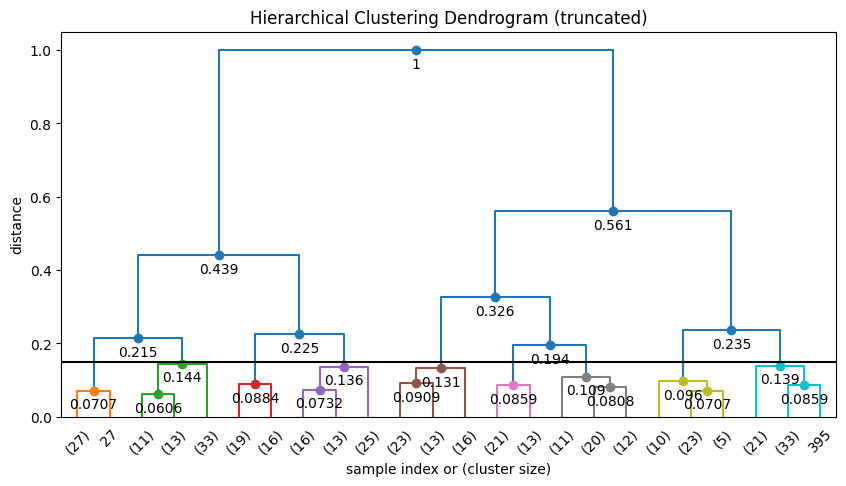

In [44]:
import matplotlib.pyplot as plt
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = sp.cluster.hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

plt.figure(figsize=(10, 5))
fancy_dendrogram(
    instance.clustering,
    truncate_mode='lastp',
    p=24,
    max_d=0.15,
)

### Training for the Probe

In [85]:
bert_model = transformers.pipeline('sentiment-analysis', top_k=None)
tokenizer = bert_model.tokenizer
sample_input = tokenizer(['heavy metal'])

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [86]:
sample_input

{'input_ids': [[101, 3082, 3384, 102]], 'attention_mask': [[1, 1, 1, 1]]}

In [89]:
sample_input = {k: torch.tensor(v) for k, v in sample_input.items()}
bert_model.model.distilbert(input_ids=sample_input['input_ids'], attention_mask=sample_input['attention_mask']).last_hidden_state.shape

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


BaseModelOutput(last_hidden_state=tensor([[[ 0.0166,  0.6803, -0.5242,  ..., -0.3184,  0.5755, -0.2461],
         [ 0.7922,  0.9616, -0.0695,  ..., -0.3873,  0.6627, -0.7247],
         [ 0.6277,  0.9892, -0.3230,  ..., -0.4605,  0.5667, -1.1881],
         [ 1.0025, -0.1171,  0.0178,  ...,  0.3121, -0.2169, -0.3875]]],
       grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)

In [79]:
## define a torch lstm model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from functools import partial

device = torch.device('cuda:0')

## use a tokenizer from the bert model
bert_model = transformers.pipeline('sentiment-analysis', top_k=None, device=device)
tokenizer = bert_model.tokenizer

class LSTM_regressor(nn.Module):
    def __init__(self, input_size=768, hidden_size=128, num_layers=2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        bert_model = transformers.pipeline('sentiment-analysis', top_k=None)
        self.embedding = bert_model.model.distilbert.eval()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.double()
    def forward(self, x):
        with torch.no_grad():
            bert_embeddings = self.embedding(**x)
        self.lstm.flatten_parameters()
        out, _ = self.lstm(bert_embeddings.last_hidden_state)
        out = self.fc(out[:, -1, :])
        return out
        
class Sentiment_Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.max_len = tokenizer.model_max_length
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        nle_input = self.df.nle[idx]
        label = self.df.max_shap_value[idx]
        return nle_input, label  

def collate_fn_base(data, tokenizer):
    nle_input, label = zip(*data)
    nle_input = tokenizer(nle_input, return_tensors="pt", padding=True)
    nle_input = {k: v.to(device) for k, v in nle_input.items()}
    return nle_input, torch.tensor(label).to(device).reshape(-1,1)
collate_fn = partial(collate_fn_base, tokenizer=tokenizer)

sample_df = pd.read_csv('../movies_400_320_nle_shap.csv')
train_size = int(0.7 * len(sample_df))
val_size = int(0.15 * len(sample_df))
idxes = np.random.permutation(len(sample_df))
train_idxes, val_idxes, test_idxes = idxes[:train_size], idxes[train_size:train_size+val_size], idxes[train_size+val_size:]
train_dataset = Sentiment_Dataset(sample_df.loc[train_idxes, :].copy().reset_index(), tokenizer)
val_dataset = Sentiment_Dataset(sample_df.loc[val_idxes, :].copy().reset_index(), tokenizer)
test_dataset = Sentiment_Dataset(sample_df.loc[test_idxes, :].copy().reset_index(), tokenizer)

train_dataloader = DataLoader(train_dataset, 
    batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
    batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset,
    batch_size=16, shuffle=False, num_workers=0, collate_fn=collate_fn)
## collate function doesnt work with n workers > 0?

model = LSTM_regressor().to('cuda')
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(len(train_dataset), len(val_dataset), len(test_dataset))


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


224 48 48


In [80]:
# best_val_loss = np.inf
best_peasonr = -np.inf
for epoch in (ep_disc:=tqdm(range(n_epochs:=32))):
    model.train()
    for (xs, ys) in train_dataloader:
        model.zero_grad()
        out = model(xs)
        loss = criterion(out, ys)
        loss.backward()
        optimizer.step()
    model.eval()
    y_true, y_pred = [], []
    for (xs, ys) in val_dataloader:
        with torch.no_grad():
            out = model(xs)
        y_true.append(ys.cpu().numpy().flatten())
        y_pred.append(out.cpu().numpy().flatten())
        val_loss = criterion(out, ys).item()

    y_true, y_pred = np.concatenate(y_true), np.concatenate(y_pred)
    PearsonR = scipy.stats.pearsonr(y_pred, y_true)[0]
    print(f'epoch: {epoch}, train_loss {loss:.3f}, val_loss: {val_loss:.3f}, PearsonR: {PearsonR:.3f}')
    if PearsonR < best_peasonr:
        best_peasonr = PearsonR
        torch.save(model.state_dict(), 'best_model.pth')

  0%|          | 0/32 [00:00<?, ?it/s]

epoch: 0, train_loss 0.015, val_loss: 0.013, PearsonR: 0.443
epoch: 1, train_loss 0.014, val_loss: 0.012, PearsonR: 0.449
epoch: 2, train_loss 0.017, val_loss: 0.013, PearsonR: 0.456
epoch: 3, train_loss 0.018, val_loss: 0.014, PearsonR: 0.458
epoch: 4, train_loss 0.014, val_loss: 0.012, PearsonR: 0.455
epoch: 5, train_loss 0.012, val_loss: 0.012, PearsonR: 0.462
epoch: 6, train_loss 0.015, val_loss: 0.013, PearsonR: 0.441
epoch: 7, train_loss 0.012, val_loss: 0.013, PearsonR: 0.451
epoch: 8, train_loss 0.010, val_loss: 0.012, PearsonR: 0.461
epoch: 9, train_loss 0.009, val_loss: 0.015, PearsonR: 0.408
epoch: 10, train_loss 0.011, val_loss: 0.014, PearsonR: 0.436
epoch: 11, train_loss 0.017, val_loss: 0.015, PearsonR: 0.401
epoch: 12, train_loss 0.010, val_loss: 0.014, PearsonR: 0.471
epoch: 13, train_loss 0.012, val_loss: 0.015, PearsonR: 0.406
epoch: 14, train_loss 0.010, val_loss: 0.017, PearsonR: 0.376
epoch: 15, train_loss 0.010, val_loss: 0.013, PearsonR: 0.451
epoch: 16, train_l

  0%|          | 0/3 [00:00<?, ?it/s]

PearsonR: 0.475, p-value: 0.001


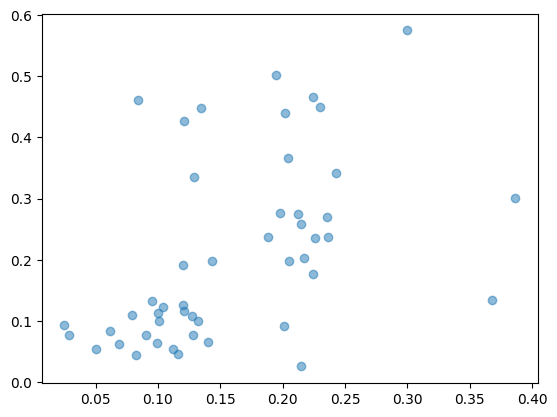

interactive(children=(IntSlider(value=23, description='idx', max=47), Output()), _dom_classes=('widget-interac…

In [87]:
some_dataloader = test_dataloader
# some_dataloader = val_dataloader

# some_dataloader = train_dataloader


model.load_state_dict(torch.load('best_model.pth'))
y_pred, y_true = [], []
for (xs, ys) in (disc:=tqdm(some_dataloader)):
    with torch.no_grad():
        out = model(xs)
    loss = criterion(out, ys)
    y_pred.append(out.cpu().numpy())
    y_true.append(ys.cpu().numpy())
    disc.set_description(f'loss: {loss.item():.3f}')
y_pred = np.vstack(y_pred).flatten()
y_true = np.vstack(y_true).flatten()
PearsonR = scipy.stats.pearsonr(y_pred, y_true)
print(f'PearsonR: {PearsonR[0]:.3f}, p-value: {PearsonR[1]:.3f}')
plt.scatter(y_pred, y_true, alpha=0.5)
plt.show()    

import ipywidgets as widgets
@widgets.interact(idx=(0, len(test_dataset)-1))
def show_sample(idx):
    x, y = test_dataset[idx]
    nle = tokenizer(x, return_tensors="pt", padding=True)
    nle = {k: v.to(device) for k, v in nle.items()}
    model.eval()
    with torch.no_grad():
        out = model(nle)
    # out, sample_df.max_shap_value[0]
    print(f'predicted: {out.item():.3f}, actual: {y:.3f}')
    print(f'input: {x}')


In [53]:
out.shape

torch.Size([16, 1])